<a href="https://colab.research.google.com/github/pilot617/Handwritten-Digit-Recognition-using-CNN/blob/master/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow #for prediction
!pip install numpy  #for matrix multiplication
!pip install pandas #define the data structures
!pip install matplotlib #for visualization
!pip install scikit-learn #for normalizing our data(scaling)

#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline


In [6]:
from google.colab import files
file = files.upload()
train = pd.read_csv("Train.csv", header=None)
# test = pd.read_csv("Test.csv", header=None)

Saving Train.csv to Train.csv


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
train = pd.read_csv(io.StringIO(file['Train.csv'].decode('utf-8')))
# train.head()
# test = pd.read_csv(io.StringIO(file['Test.csv'].decode('utf-8')))
train.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW]
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583


In [10]:
# data_pm = train.iloc[:, 3]
# list = []
# i=0
# while i<5000:
#   val = sum(data_pm[i*60:(i+1)*60])
#   list.append(val)
#   i += 1
# list
# sr = pd.Series(list, index= range(5000))
# data_to_use = sr.rename('House overall [kW]')
# data_to_use.head()
data_to_use = train.iloc[:, 3]
data_to_use.shape

(300000,)

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


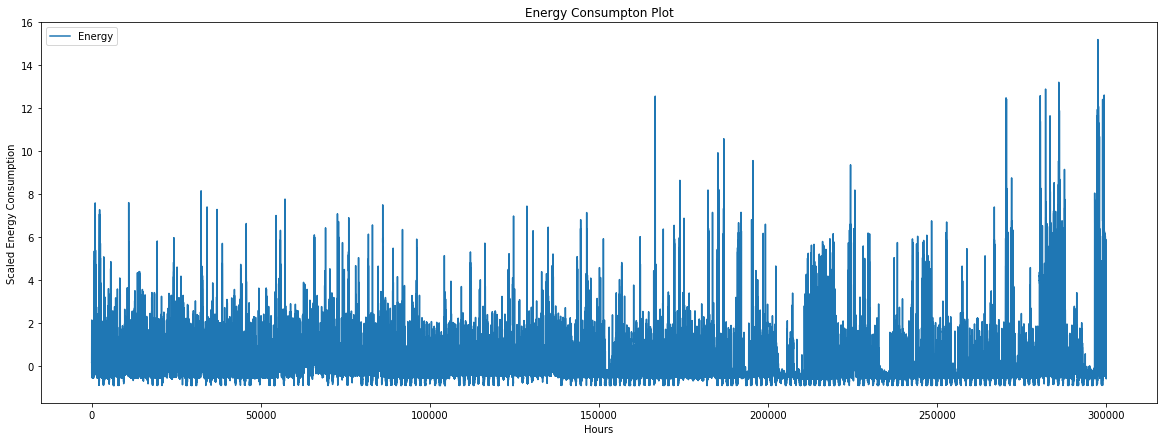

In [11]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.values.reshape(-1, 1))
# plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Energy Consumpton Plot')
plt.xlabel('Hours')
plt.ylabel('Scaled Energy Consumption')
plt.plot(scaled_data, label='Energy')
plt.legend()
plt.show()

In [19]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
X, y = window_data(scaled_data, 7)
# len(y)

#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:3000])
y_train = np.array(y[:3000])

X_test = np.array(X[3000:3500])
y_test = np.array(y[3000:3500])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (3000, 7, 1)
y_train size: (3000, 1)
X_test size: (500, 7, 1)
y_test size: (500, 1)


In [20]:
#we now define the network
#Hyperparameters used in the network
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 500

import tensorflow as tf
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])



#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_959:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1023:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1087:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1151:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1215:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1279:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1343:0' shape=(1, 1) dtype=float32>]

In [21]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 20) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/500  Current loss: 0.3788810074329376
Epoch 20/500  Current loss: 0.21151354908943176
Epoch 40/500  Current loss: 0.1654895842075348
Epoch 60/500  Current loss: 0.11764874309301376
Epoch 80/500  Current loss: 0.09482251852750778
Epoch 100/500  Current loss: 0.07979977875947952
Epoch 120/500  Current loss: 0.05480153113603592
Epoch 140/500  Current loss: 0.03884812071919441
Epoch 160/500  Current loss: 0.028094224631786346
Epoch 180/500  Current loss: 0.04868612438440323
Epoch 200/500  Current loss: 0.03243757411837578
Epoch 220/500  Current loss: 0.02429741993546486
Epoch 240/500  Current loss: 0.017673322930932045
Epoch 260/500  Current loss: 0.024959878996014595
Epoch 280/500  Current loss: 0.022547703236341476
Epoch 300/500  Current loss: 0.019091548398137093
Epoch 320/500  Current loss: 0.012904244475066662
Epoch 340/500  Current loss: 0.012758968397974968
Epoch 360/500  Current loss: 0.012768763117492199
Epoch 380/500  Current loss: 0.00900840014219284
Epoch 400/500  Curre

In [0]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [0]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [28]:
tests_new = []
for i in range(len(tests)):
  for j in range(len(tests[i][0])):
    tests_new.append(tests[i][0][j])
len(tests_new)

497

In [45]:
test_results = []
for i in range(3500):
      if i >= 3005:
        test_results.append(tests_new[i-3005])
      else:
        test_results.append(None)
len(test_results)

3500

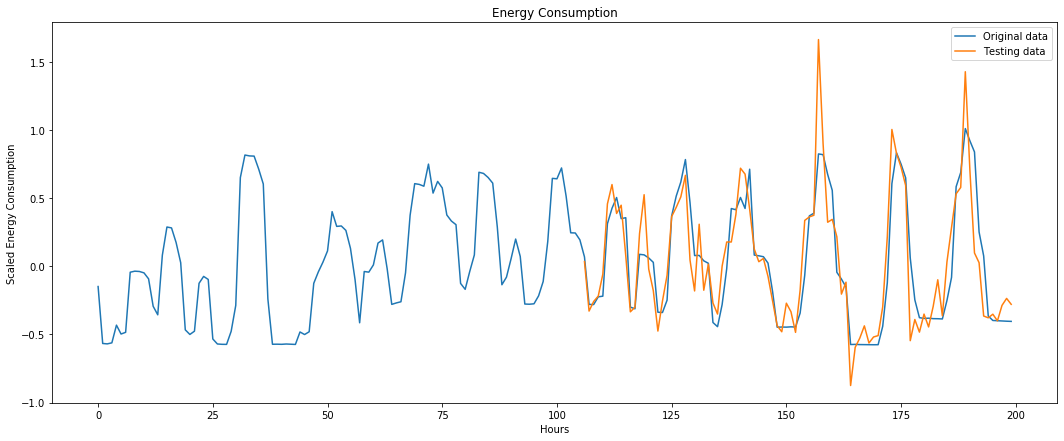

In [40]:
#we now plot predictions from the network
plt.figure(figsize=(18, 7))
plt.title('Energy Consumption')
plt.xlabel('Hours')
plt.ylabel('Scaled Energy Consumption')
plt.plot(scaled_data[2900:3100], label='Original data')
# plt.plot(sup[2900:3100], label='Training data')
plt.plot(test_results[2900:3100], label='Testing data')
plt.legend()
plt.show()

In [0]:
mean_of_array = data_to_use.values.reshape(-1, 1).mean(axis=0)
std_of_array = data_to_use.values.reshape(-1, 1).std(axis=0)
# test_results[3001]
op = np.array(test_results)
original_test_results = op[3006:].reshape(-1, 1)*std_of_array + mean_of_array
# original_test_results.shape
original_y_test = y_test*std_of_array + mean_of_array
original_y_test = original_y_test[0:500]
original_y_test.shape
original_test_results

In [152]:
# sr = pd.Series(y[3000:3500], index=range(500))
# sr = sr*std_of_array + mean_of_array
# # sr.shape
# # # original_test_results
# sr.to_csv('original_test_results.csv') 
# files.download('original_test_results.csv')
MAPE = []
i = 1
for i in range(124):
  tmp = 0
  for j in range(i+1):
    # tmp = 0
    tmp = tmp + abs((original_y_test[j]-original_test_results[j])/original_y_test[j])
    j += 1;
  tmp = tmp*100/(i+1)
  MAPE.append(tmp);
  i += 1
APE = []
i = 1
for i in range(24):
  tmp = 100*abs((original_y_test[100 + i]-original_test_results[100 + i])/original_y_test[100 + i])
  APE.append(tmp)
  i += 1
# APE
sp = []
for i in range(24):
  # tmp=0
  if APE[i]<=MAPE[100 + i]:
    sp.append(0)
  else:
    sp.append(1)
SMA = []
for i in range(124):
  tmp = 0
  for j in range(i+1):
    tmp += original_y_test[j]
  tmp = tmp/(i+1)
  SMA.append(tmp)
SMAmd = abs(SMA[101]-SMA[100])
i=1
while i<=23:
  SMAmd = max(SMAmd, abs(SMA[100+i]-SMA[100+i-1]))
  i += 1
# SMAmd
sh = []
i=1
while i<=23:
  if SMA[100+i] - SMA[100+i-1] <= (3/4)*SMAmd:
    sh.append(0)
  else:
    sh.append(1)
  i += 1
# temp = [0.6122, 1.33105, 0.9699, 0.3034, 0.872483]
# SMA1 = []
# for i in range(5):
#   tmp = 0
#   for j in range(i+1):
#     tmp += temp[j]
#   tmp = tmp/(i+1)
#   SMA1.append(tmp)
# # SMA1
# SMAmd = abs(SMA1[1]-SMA1[0])
# i=1
# while i<=4:
#   SMAmd = max(SMAmd, abs(SMA1[i]-SMA1[i-1]))
#   i += 1
# SMAmd
# sh = []
# i=1
# while i<=4:
#   if SMA1[i] - SMA1[i-1] <= (3/4)*SMAmd:
#     sh.append(0)
#   else:
#     sh.append(1)
#   i += 1
# sh
Pmx = 0
i = 2900
while i<=3010:
  Pmx = max(Pmx, data_to_use[i])
  i +=1
# data_to_use[3010]
Pmx
setn = []
i=0
while i<=4:
  if temp[i] >= (3/4)*1.25:
    setn.append(0)
  else:
    setn.append(1)
  i += 1
# data_to_use
sh

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [0]:
ad = []
for i in range(24):
  ad.append(original_y_test[100+i][0])

pd = []
for i in range(24):
  pd.append(original_test_results[100+i][0][0][0])
mape = []
for i in range(24):
  mape.append(SMA[100+i][0])
# data_to_use[3107]
mape

In [70]:
error = 0
for i in range(24):
  error += abs(original_test_results[i] - original_y_test[i])*100/original_y_test[i]
error /= 24
print(error)

[array([[13.915872]], dtype=float32)]
